In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
!{sys.executable} -m pip install scipy
from scipy import stats

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/keanu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/keanu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/keanu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from perceval.backends.core.github import GitHub
import os,json
import nltk.data
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import augur
import sqlalchemy as s
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline

In [3]:
augurApp = augur.Application('../augur.config.json')
list1,path = augurApp.github_issues()
DB_STR = 'mysql+pymysql://{}:{}@{}:{}/{}?charset=utf8'.format(
            list1[0], list1[1], list1[2],\
            list1[3], list1[4]
        )
db = s.create_engine(DB_STR)

In [6]:
table_names = s.inspect(db).get_table_names()
print(table_names)

['github_issues', 'github_issues_sentiment_scores', 'issue_response_time', 'mail_lists', 'mail_lists_sentiment_scores', 'mailing_list_jobs']


In [7]:
if("github_issues" in table_names):
    lists_createdSQL = s.sql.text("""SELECT repo FROM github_issues""")
    df1 = pd.read_sql(lists_createdSQL, db)
    #print(df1)
    val = True

In [8]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
col = 'score','sentiment'

In [9]:
SQL = """SELECT * FROM github_issues"""
df_users =  pd.read_sql(SQL, db)
print(df_users.head(10))

   augurmsgID backend_name                      repo_link   owner repo  \
0           1       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
1           2       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
2           3       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
3           4       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
4           5       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
5           6       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
6           7       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
7           8       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
8           9       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
9          10       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   

                 subject  status category  issue_number   timestamp  \
0  Purpose of nodejs/CTC  closed    issue             1  1532522618   
1  Purpose of nodejs/CTC  closed    issue  

In [10]:
grouped = df_users.groupby('subject').groups
num = 0
col = 'score','sentiment'
columns1 = 'augurmsgID',"backend_name",'repo_link',"owner","repo","subject",\
          "status","category","issue_number","timestamp",\
          "issue_id","user","body"
df3 = pd.DataFrame(columns=col)
df_list = pd.DataFrame(columns = columns1)
df_list = df_list.append(df_users)
for group in grouped:
    #print(group)
    issue_num = (df_users.loc[df_users['subject'] == group]['issue_number']).values
    messages = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    id1 = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    #print("Issue number: ",issue_num[0])
    #break
    for i in messages:
        #print(i)
        sentences = tokenizer.tokenize(i)
        compound = 0
        part = 0
        sentiment = "Positive"
        for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            compound+=scores['compound']
            part+=1
            #print(sentence,scores)
            #if(scores['compound'] < 0.1):
            #    print(sentence,scores['compound'])
        avg = compound/part
        avg = round(avg,3)
        if(avg == 0):
            sentiment = "Neutral"
        elif(avg < 0):
            sentiment = "Negative"
        li = [ [avg,sentiment]]
        df_temp = pd.DataFrame(li,columns=col)
        df3 = df3.append(df_temp)
        #if(avg < -0.5):
            #print(i,avg)
            #print("\n\n\n\n\n\n")
    #if(num == 40):
    #    break
    num+=1
    #print("\n\n\n")
print(num)

126


In [11]:
#print(df3)
#print(df_list)
df3 = df3.reset_index(drop=True)
#print(df3.head())
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

In [12]:
print(combine.head())

  augurmsgID backend_name                      repo_link   owner repo  \
0          1       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
1          2       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
2          3       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
3          4       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   
4          5       GitHub  https://github.com/nodejs/CTC  nodejs  CTC   

                 subject  status category issue_number   timestamp   issue_id  \
0  Purpose of nodejs/CTC  closed    issue            1  1532522618  159398443   
1  Purpose of nodejs/CTC  closed    issue            1  1532522618  159398443   
2  Purpose of nodejs/CTC  closed    issue            1  1532522618  159398443   
3  Purpose of nodejs/CTC  closed    issue            1  1532522618  159398443   
4  Purpose of nodejs/CTC  closed    issue            1  1532522618  159398443   

          user                                               body  score  

In [13]:
combine.to_sql(name='github_issues_sentiment_scores',\
               con=db,if_exists='replace',index=False)

(126,)
(126,)


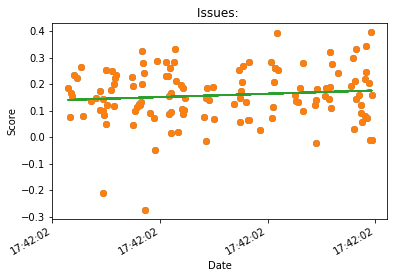

In [31]:
grouped = combine.groupby('subject').groups
dates = []
values = []
fin_dates = []
fin_values = []
mail_list = None
j = 0
for group in grouped:
    #print(group)
    dates = (combine.loc[combine['subject'] == group]['timestamp']).tolist()
    values = (combine.loc[combine['subject'] == group]['score']).unique().tolist()
    #print("Issue number: ",issue_num[0])
    x = np.array(dates)
    dates = np.unique(x)
    #print(dates)
    dates = [pd.to_datetime(x,unit='ms') for x in dates]
    #print(dates)
    dates1 = [x for x in dates]
    #dates2 = mdates.date2num(dates1)
    #print(dates1)
    #print(values)
    values = sum(values[0:len(values)])/len(values)
    fin_dates.append(dates1[0])
    fin_values.append(values)
    # beautify the x-labels
    #plot.savefig('mailing_list' + str(j) + '.png')
        #if(avg < -0.5):
            #print(i,avg)
            #print("\n\n\n\n\n\n")
    #if(num == 40):
    #    break
    num+=1
    #print("\n\n\n")
    j+=1
fin_dates = mdates.date2num(fin_dates)
fin_values = np.asarray(fin_values)
print(fin_dates.shape)
print(fin_values.shape)
plot.plot_date(fin_dates, fin_values)
#plot.plot(fin_dates,fin_values)
plot.gcf().autofmt_xdate()
plot.title("Issues: ")
plot.ylabel('Score')
plot.xlabel('Date')
#print(fin_dates)
slope, intercept, r_value, p_value, std_err = stats.linregress(fin_dates,fin_values)
line = slope*fin_dates+intercept
plot.plot(fin_dates,fin_values,'o', fin_dates, line)